# DeepLabV3 VOC 2012

In [29]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle




## Dataset : Pascal VOC 2012

In [2]:
dataroot = '/data/voc2012'



In [3]:


def change_type_input(img):
  return img.float()

def to_tensor_target(img):
  img = np.array(img)
  # border
  img[img==255] = 0 # border = background 
  return torch.LongTensor(img)

def padding(img,pad=(6,9)):
    return transforms.functional.pad(img, pad, fill=0, padding_mode='constant')

size = (513,513)
transform_input = transforms.Compose([
                                   #transforms.Lambda(padding),
                                   transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

transform_mask = transforms.Compose([
                                   #transforms.Lambda(padding),
                                   transforms.Resize(size),
                                   transforms.Lambda(to_tensor_target)
                                   ])


In [26]:
train_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='train', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

val_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='val', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


### Split dataset

In [42]:
class Split_Dataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
percent = 0.3
split = int(len(train_dataset)*0.3)
lengths = [split,len(train_dataset)-split]
subsetA, subsetB = random_split(train_dataset, lengths)
train_dataset = Split_Dataset(
    subsetA)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([3, 513, 513])
torch.Size([513, 513, 3])


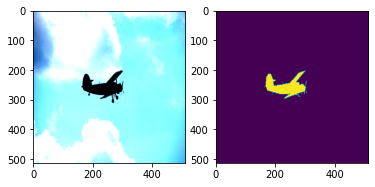

torch.Size([513, 513])

In [45]:
"""Pascal VOC Dataset Segmentation Dataloader"""


VOC_CLASSES = ('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor')

NUM_CLASSES = len(VOC_CLASSES) + 1



sample = train_dataset.__getitem__(0)
image, mask = sample[0], sample[1]
print(type(image))
print(image.size())
image.transpose_(0, 2)
image.transpose_(0, 1)
print(image.size())

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(image)    #.transpose(0,1)

a = fig.add_subplot(1,2,2)
plt.imshow(mask)

plt.show()
mask.size()


In [46]:

# Set batch_size
batch_size = 4

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)



device : cuda:0


In [47]:
print("Taille dataset train :",len(train_dataset))
print("Taille dataset val :",len(val_dataset))

Taille dataset train : 439
Taille dataset val : 1449


## Metric code

In [48]:
SMOOTH = 1e-6
def iou(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    #iou_metric = ((iou-0.5)*2*10).floor()/10
    #iou_metric[iou_metric<0] = 0

    return iou.mean()  # Or thresholded.mean() if you are interested in average across the batch
    


 
iou(next(iter(dataloader_val))[1],next(iter(dataloader_train))[1])

tensor(0.0529)

In [49]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) + label_pred[mask],
        minlength=n_class ** 2,
    ).reshape(n_class, n_class)
    return hist


def scores(label_trues, label_preds, n_class=21):
    label_trues = label_trues.cpu().numpy()
    label_preds = label_preds.cpu().numpy()
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    valid = hist.sum(axis=1) > 0  # added
    mean_iu = np.nanmean(iu[valid])
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    cls_iu = dict(zip(range(n_class), iu))

    return {
        "Pixel Accuracy": acc,
        "Mean Accuracy": acc_cls,
        "Frequency Weighted IoU": fwavacc,
        "Mean IoU": mean_iu,
        "Class IoU": cls_iu,
    }

In [50]:
def evaluate_model(model,val_loader,criterion=nn.CrossEntropyLoss(ignore_index=21),nclass=21):
  loss_test = []
  iou_test = []
  pixel_accuracy = []
  weight_iou = []
  with torch.no_grad():
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)

          model.eval()
          pred = model(x)


          loss = criterion(pred,mask)
          loss_test.append(loss.item())
          
          s = scores(pred.max(dim=1)[1],mask)
          ioU = float(iou(pred.argmax(dim=1),mask))
          """
            return {
              "Pixel Accuracy": acc,
              "Mean Accuracy": acc_cls,
              "Frequency Weighted IoU": fwavacc,
              "Mean IoU": mean_iu,
              "Class IoU": cls_iu,
          }
          """
          iou_test.append(ioU)
          pixel_accuracy.append(s["Pixel Accuracy"])
          weight_iou.append(s["Frequency Weighted IoU"])

    

    print("Mean IOU :",np.array(iou_test).mean(),"Frequency Weighted IOU :",np.array(weight_iou).mean(),\
          "Pixel Accuracy :",np.array(pixel_accuracy).mean(),"Loss Validation :",np.array(loss_test).mean())

In [51]:
def save_loss(model_name):
    save = os.path.join(SAVE_DIR,model_name+'_loss_train.npy')
    np.save(save,np.array(loss_train))
    save = os.path.join(SAVE_DIR,model_name+'_loss_test.npy')
    np.save(save,np.array(loss_test))
    save = os.path.join(SAVE_DIR,model_name+'_iou_train.npy')
    np.save(save,np.array(iou_train))
    save = os.path.join(SAVE_DIR,model_name+'_iou_test.npy')
    np.save(save,np.array(iou_test))


## DeepLabV3 Pytorch

In [52]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Training

In [53]:
learning_rate = 0.02
moment = 0.9
wd = 1e-4
n_epochs = 30
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / (len(dataloader_train) * n_epochs)) ** 0.9)

#writer = SummaryWriter()
criterion = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.

In [54]:
SAVE_DIR = '/data/model'
model_name = 'deeplab30'
save = os.path.join(SAVE_DIR,'deeplabv3_30_voc.pt')
iou_train = []
loss_train = []
iou_test = []
loss_test = []
all_loss_train = []
all_loss_test = []
all_iou = []

In [ ]:
for ep in range(n_epochs):
    print("EPOCH",ep)

    for i,(x,mask) in enumerate(dataloader_train):
          x = x.to(device)
          mask = mask.to(device)
          model.train()
          pred = model(x)
          pred = pred["out"]
          loss = criterion(pred,mask)
          all_loss_train.append(loss.item())
          optimizer.zero_grad()
          loss.backward()
          all_iou.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))
          optimizer.step()
          lr_scheduler.step()
          

    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss_train).mean()
    loss_train.append(m_loss)
    iou_train.append(m_iou)
    all_loss_train = []
    all_iou = []
    print("EP:",ep," loss train:",m_loss," iou train:",m_iou)
    
    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)
          model.eval()
          with torch.no_grad():
            pred = model(x)
            pred = pred["out"]
          loss = criterion(pred,mask)
          all_loss_test.append(loss.item())
          all_iou.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))
    
    m_iou = np.array(all_iou).mean()
    m_loss = np.array(all_loss_test).mean()
    loss_test.append(m_loss)
    iou_test.append(m_iou)
    all_loss_test = []
    all_iou = []
    print("EP:",ep," loss test:",m_loss," iou test:",m_iou)


    torch.save(model,save)
    save_loss(model_name)

EPOCH 0


In [ ]:
save_loss('deeplab30')

## Plot

In [ ]:
x,mask = next(iter(dataloader_val))
i = 1
x = x.to(device)
mask = mask.to(device)
pred = model(x)
pred = pred["out"]
fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(pred.max(dim=1)[1][i].cpu())

a = fig.add_subplot(1,2,2)
plt.imshow(mask.cpu().detach().numpy()[i])

plt.show()

class_pred = []
class_mask = []

for p in pred.argmax(dim=1)[i].unique():
  class_pred.append(VOC_CLASSES[int(p)])
for m in mask[i].unique():
  class_mask.append(VOC_CLASSES[int(m)])

print("Classe prédite : ",class_pred)
print("Classe réelle : ",class_mask)
print(scores(pred.argmax(dim=1)[i],mask[i])["Pixel Accuracy"])
print("IOU sur ce masque :",float(iou(pred.argmax(dim=1)[i].unsqueeze(0),mask[i].unsqueeze(0))))


In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s loss train")
plt.plot(loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s mean iou train")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("FCNET 32s mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")